# Compute embeddings of RNAs with multiple functions

In [1]:
from embedding import seq2embedding
import torch
import os
import random
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm

/opt/anaconda3/envs/torch201/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Process data

In [2]:
# work dir
os.chdir('/picb/rnasys2/zhouhanwen/nucTran/github/')

In [3]:
# RNAs from GENCODE
rna_df = pd.read_csv('embedding/data/Rna/rna_gencode.tsv', sep='\t')
rna_df = rna_df[rna_df['label'].isin(['protein_coding', 'lncRNA', 'snRNA', 'miRNA', 'snoRNA', 'tRNA', 'rRNA', 'scaRNA', 'Mt_tRNA', 'Mt_rRNA'])]
rna_df['label'].value_counts()

label
protein_coding    89411
lncRNA            56138
snRNA              1901
miRNA              1879
snoRNA              942
tRNA                649
scaRNA               49
rRNA                 47
Mt_tRNA              22
Mt_rRNA               2
Name: count, dtype: int64

In [4]:
# Sample one transcript from each gene in order to avoid similar sequences
np.random.seed(2024)
rna_sample_df = rna_df.groupby('gene_id').sample(1)
print(len(rna_sample_df))

44021


In [5]:
# Select transcripts shorter than 4096 nucleotides
rna_sample_df['seq_len'] = rna_sample_df['seq'].apply(lambda x: len(x))
rna_sample_df = rna_sample_df[rna_sample_df['seq_len'] <= 4096]
print(len(rna_sample_df))
rna_sample_df['label'].value_counts()

40007


label
lncRNA            18396
protein_coding    16120
snRNA              1901
miRNA              1879
snoRNA              942
tRNA                649
scaRNA               49
rRNA                 47
Mt_tRNA              22
Mt_rRNA               2
Name: count, dtype: int64

In [6]:
# Select 6 classes of RNAs with N > 100
rna_sample_df = rna_sample_df[rna_sample_df['label'].isin(['protein_coding', 'lncRNA', 'snRNA', 'miRNA', 'snoRNA', 'tRNA'])]
print(len(rna_sample_df))

39887


## Compute embeddings

In [7]:
rna_seqs = rna_sample_df['seq'].values.tolist()
labels = rna_sample_df['label'].values.tolist()

In [8]:
model_state_path = 'pretrain/saving_model/mammalian80D_4096len1mer1sw_80M/checkpoint-250000/model.safetensors'
# model_state_path = None
model_max_length = 15000

In [9]:
embeddings, embedding_means = seq2embedding(rna_seqs, 'sequence', model_state_path, model_max_length, return_embedding=False)

100%|█████████████████████████████████████████████████████████████████████████████| 39887/39887 [32:51<00:00, 20.23it/s]


In [ ]:
embedding_means

In [12]:
embedding_means = np.array(embedding_means)
embedding_means.shape

(39887, 768)

In [13]:
np.save('embedding/data/Rna/rna_gencode_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_RNA_lt4096.npy', embedding_means)
# np.save('embedding/data/Rna/rna_gencode_embedding_mean_no_pretrain_80M_RNA_lt4096.npy', embedding_means)

## Compute NMI

In [14]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embedding_means)

In [15]:
normalized_mutual_info_score(labels, cluster_labels)

0.3273598742860172

In [16]:
label_df = pd.DataFrame({'predict_label': cluster_labels, 'true_label': labels})
pd.crosstab(label_df['true_label'], label_df['predict_label'])

predict_label,0,1,2,3,4,5
true_label,,,,,,
lncRNA,296,5904,222,7265,4316,393
miRNA,43,725,24,912,171,4
protein_coding,401,1248,6358,762,1256,6095
snRNA,1482,2,0,232,184,1
snoRNA,38,78,0,773,53,0
tRNA,189,5,0,24,431,0


## tSNE

In [17]:
tsne = TSNE(n_components=2, init='pca', verbose=2, random_state=2024)
tsne_array = tsne.fit_transform(embedding_means)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 39887 samples in 0.023s...
[t-SNE] Computed neighbors for 39887 samples in 8.647s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39887
[t-SNE] Computed conditional probabilities for sample 2000 / 39887
[t-SNE] Computed conditional probabilities for sample 3000 / 39887
[t-SNE] Computed conditional probabilities for sample 4000 / 39887
[t-SNE] Computed conditional probabilities for sample 5000 / 39887
[t-SNE] Computed conditional probabilities for sample 6000 / 39887
[t-SNE] Computed conditional probabilities for sample 7000 / 39887
[t-SNE] Computed conditional probabilities for sample 8000 / 39887
[t-SNE] Computed conditional probabilities for sample 9000 / 39887
[t-SNE] Computed conditional probabilities for sample 10000 / 39887
[t-SNE] Computed conditional probabilities for sample 11000 / 39887
[t-SNE] Computed conditional probabilities for sample 12000 / 39887
[t-SNE] Computed conditional probabilities for sam

In [18]:
color_map = {'protein_coding': 0, 'lncRNA': 1, 'snRNA': 2, 'miRNA': 3, 'snoRNA': 4, 'tRNA': 5}

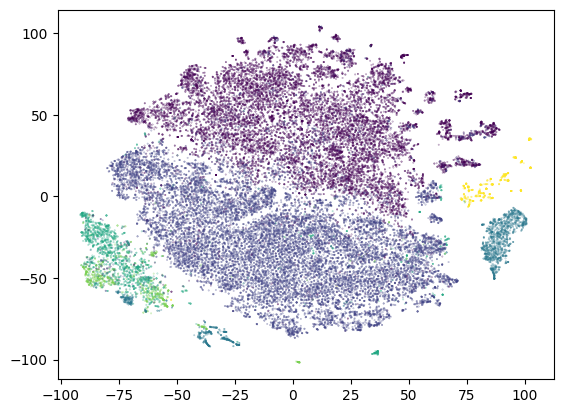

In [19]:
plt.scatter(tsne_array[:, 0], tsne_array[:, 1], alpha=0.5, s=0.1, c=rna_sample_df['label'].map(color_map))

In [20]:
tsne_df = pd.DataFrame(tsne_array)
tsne_df.columns = ['tsne1', 'tsne2']
tsne_df['seq_len'] = rna_sample_df['seq'].apply(lambda x: len(x)).values.tolist()
tsne_df['label'] = labels

In [21]:
tsne_df.to_csv('embedding/data/Rna/rna_gencode_6class_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_RNA_lt4096_tsne.tsv', sep='\t', index=False)
# tsne_df.to_csv('embedding/data/Rna/rna_gencode_6class_embedding_mean_no_pretrain_80M_RNA_lt4096_tsne.tsv', sep='\t', index=False)